In [1]:
import math
import json
import string
from os import path
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Align import AlignInfo
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [142]:
def separate_clades(cov, gene):
#     if cov == 'hku1':
#         clade_file = '../'+str(cov)+'/results/clades_full.json'

    if path.exists('../'+str(cov)+'/results/clades_'+str(gene)+'.json'):
        clade_file = '../'+str(cov)+'/results/clades_'+str(gene)+'.json'

#         if gene =='spike' or gene == 's1' or gene == 's2':
#             clade_file = '../'+str(cov)+'/results/clades_spike.json'
    else:
        clade_file = '../'+str(cov)+'/results/clades_full.json'
    
    clade_lists = []
    with open(clade_file, "r") as clade_handle:
        clades = json.load(clade_handle)
        for node, v in clades['nodes'].items():
            if 'NODE' not in node:
                clade_lists.append({'clade':v['clade_membership'],
                                   'strain':node})

    clade_df = pd.DataFrame(clade_lists)
    return clade_df

In [183]:
#Kappa is estimated by BEAST and can be found in the .log file within seasonal-cov/beast/cov/gene/
#For each CoV, kappa is the average of the kappa values estimated for the spike and rdrp trees 
def weight_by_kappa(start_nt, mut_nt, codon_pos, cov, lineage):
    if lineage!=None:
        cov_lineage = cov+lineage
    else:
        cov_lineage = cov

    kappa_values = {'oc43A':{'kappa12': 6.041, 'kappa3': 10.503}, 
                    'oc43B':{'kappa12': 6.030, 'kappa3': 11.729}, 
                    '229e':{'kappa12': 3.108, 'kappa3': 9.547}, 
                    'nl63':{'kappa12': 3.387, 'kappa3': 9.684},
                    'hku1':{'kappa12': 3.465, 'kappa3': 10.474},
                    'hku1A':{'kappa12': 3.394, 'kappa3': 10.525},
                    'hku1B':{'kappa12': 3.371, 'kappa3': 10.317}
                   }
    
    if codon_pos == 2:
        kappa = kappa_values[cov_lineage]['kappa3']
        #kappa=weight_tv/weight_ti
        #weight_ti+weight_tv=1
        weight_tv = 1/(1+kappa)
        weight_ti = 1-weight_tv
    else:
        kappa = kappa_values[cov_lineage]['kappa12']
        weight_tv = 1/(1+kappa)
        weight_ti = 1-weight_tv
    
    transitions = {'T': 'C', 'C':'T', 'A':'G', 'G':'A'}
    
    if mut_nt == transitions[start_nt]:
        return(weight_ti)
    else:
        return(weight_tv)

In [143]:
#iterate through all possible mutations and tally how many would be syn vs nonsyn
def find_nonsyn_syn_denominators(seq, aa_seq, cov, lineage):
    
    seq = str(seq)
    aa_seq = str(aa_seq)
    
    nonsyn_denominator = 0
    syn_denominator = 0
    
    all_nts = ['A', 'C', 'G', 'T']
    
    for pos in range(len(seq)):
        nt = seq[pos]
        if nt!='N':

            codon = math.floor(pos/3)
            codon_pos = pos-(codon*3)
            real_codon_aa = aa_seq[codon]

            all_other_nts = [x for x in all_nts if x != nt]
            for mutated_nt in all_other_nts: 
                if codon_pos == 0:
                    mut_codon_nt = mutated_nt+seq[pos+1:(pos+3)]
                elif codon_pos == 1:
                    mut_codon_nt = seq[pos-1]+mutated_nt+seq[pos+1]
                elif codon_pos == 2:
                    mut_codon_nt = seq[(pos-2):pos]+mutated_nt

                mut_codon_aa = Seq(mut_codon_nt).translate()

                if mut_codon_aa!=real_codon_aa:
                    nonsyn_denominator+=weight_by_kappa(nt, mutated_nt, codon_pos, cov, lineage)
                elif mut_codon_aa==real_codon_aa:
                    syn_denominator+=weight_by_kappa(nt, mutated_nt, codon_pos, cov, lineage)

        
    return(nonsyn_denominator, syn_denominator)

In [79]:
def find_founder_consensus(virus_time_subset,input_file_alignment, min_seqs):
    
    #strains at first time point(to make consensus from)
    first_window = True
    first_window_strains = []
    first_window_sequences = []
    first_window_years = ''
    root_seq = ''
    root_aa_seq = ''
    
    for years, subset_viruses in virus_time_subset.items():
    #don't use windows with fewer than min_seqs 
        if len(subset_viruses) >= min_seqs:


            #make consensus sequence at first time point
            if first_window == True:
                first_window_years = years
                first_window_strains+=subset_viruses
                with open(input_file_alignment, "r") as aligned_handle:
                    for virus in SeqIO.parse(aligned_handle, "fasta"):
                        if virus.id in first_window_strains:
                            first_window_sequences.append(virus)

                first_window_alignment = MultipleSeqAlignment(first_window_sequences)
                root_seq = AlignInfo.SummaryInfo(first_window_alignment).dumb_consensus(ambiguous ='N')
                root_aa_seq = root_seq.translate()

                first_window = False
    
    return(root_seq, root_aa_seq, first_window_years)

In [182]:
def divergence_weighted(cov, gene, window, clade, min_seqs, year_max=None, year_min=None):
    #Find fraction of sites that differ from root and average among all viruses at each time point
    input_file_root = '../'+str(cov)+'/auspice/seasonal_corona_'+str(cov)+'_'+str(gene)+'_root-sequence.json'
    input_file_alignment = '../'+str(cov)+'/results/aligned_'+str(cov)+'_'+str(gene)+'.fasta'
    metafile = '../'+str(cov)+'/results/metadata_'+str(cov)+'_'+str(gene)+'.tsv'
    
    #Subset data based on time windows
    meta = pd.read_csv(metafile, sep = '\t')
    meta.drop(meta[meta['date']=='?'].index, inplace=True)
    meta.dropna(subset=['date'], inplace=True)
    meta['year'] = meta['date'].str[:4].astype('int')
    
    if year_max:
        meta.drop(meta[meta['year']>year_max].index, inplace=True)
    if year_min:
        meta.drop(meta[meta['year']<year_min].index, inplace=True)
    
    #Remove HKU1 and NL63 outgroup (that was used to root)
    meta.drop(meta[meta['strain']=='hku14_3/JN874560/HKU1/china/2007'].index, inplace=True)
    meta.drop(meta[meta['strain']=='mhv/NC_048217_1/mhv/2006'].index, inplace=True)
    meta.drop(meta[meta['strain']=='229e/AF304460/229e_ref/Germany/2000'].index, inplace=True)
    
    date_range = meta['year'].max() - meta['year'].min()
    
    
    if clade!= None:
        clade_df = separate_clades(cov, gene)
        meta = meta.merge(clade_df, on='strain')
        meta.drop(meta[meta['clade']!=clade].index, inplace=True)

    #Group viruses by time windows
    virus_time_subset = {}
    if window == 'all':
        years = str(meta['year'].min()) + '-' + str(meta['year'].max())
        virus_time_subset[years] = meta['strain'].tolist()
    else:
        date_window_start = meta['year'].min()
        date_window_end = meta['year'].min() + window
        while date_window_end <= meta['year'].max():
            years = str(date_window_start) + '-' + str(date_window_end)
            strains = meta[(meta['year']>=date_window_start) & (meta['year']<date_window_end)]['strain'].tolist()
            virus_time_subset[years] = strains
            #sliding window
            date_window_end += 1
            date_window_start += 1     
    
    root_seq, root_aa_seq, first_window_years = find_founder_consensus(virus_time_subset,input_file_alignment, min_seqs)
    
    nonsyn_denominator, syn_denominator = find_nonsyn_syn_denominators(root_seq, root_aa_seq, cov, clade)

    
    #initiate lists to record all time windows
    year_windows = []
    seqs_in_window = []
    nonsyn_divergences = []
    syn_divergences = []
    nonsyn_divergences_window_average = []
    syn_divergences_window_average = []

    
    for years, subset_viruses in virus_time_subset.items():
    #don't use windows with fewer than min_seqs 
        if len(subset_viruses) >= min_seqs:
            year_windows.append(years)
            seqs_in_window.append(len(subset_viruses))
            

            syn_div_allviruses_in_window = []
            nonsyn_div_allviruses_in_window  = []
            with open(input_file_alignment, "r") as aligned_handle:
                for virus in SeqIO.parse(aligned_handle, "fasta"):         
                    #Only viruses in time window
                    if virus.id in subset_viruses:    
                        #check
                        if len(virus.seq) != len(root_seq):
                            print(virus)
                        elif len(virus.seq) == len(root_seq):
                            count_total_unambiguous = 0
                            count_subs = 0
                            count_syn_subs = 0
                            count_nonsyn_subs = 0
                            for pos in range(len(root_seq)):
                                root_nt = str(root_seq[pos])
                                virus_nt = str(virus.seq[pos])
                                #skip ambiguous sites
                                if virus_nt != 'N':
                                    if root_nt != 'N':
                                        count_total_unambiguous+=1
                                        if virus_nt != root_nt:
                                            count_subs+=1
                                            #determine syn or nonsyn
                                            codon = math.floor(pos/3)
                                            codon_pos = pos-(codon*3)
                                            if codon_pos == 0:
                                                codon_nt = virus.seq[pos:(pos+3)]
                                            elif codon_pos == 1:
                                                codon_nt = virus.seq[(pos-1):(pos+2)]
                                            elif codon_pos == 2:
                                                codon_nt = virus.seq[(pos-2):(pos+1)]
                                            codon_aa = codon_nt.translate()
                                            root_aa = root_aa_seq[codon]
                                            #skip ambiguous
                                            if root_aa != 'X':
                                                if codon_aa != root_aa:
                                                    count_nonsyn_subs+=1
                                                elif codon_aa == root_aa:
                                                    count_syn_subs+=1


                            #Multiply div by fraction of sites that were unambiguously sequenced
                            unambiguous_ratio = count_total_unambiguous/len(root_seq)
                            syn_div_for_virus = (count_syn_subs*unambiguous_ratio)/(syn_denominator*unambiguous_ratio)
#                             syn_div_for_virus = (count_syn_subs)/(syn_denominator)
                            syn_div_allviruses_in_window.append(syn_div_for_virus)
                            nonsyn_div_for_virus = (count_nonsyn_subs*unambiguous_ratio)/(nonsyn_denominator*unambiguous_ratio)
#                             nonsyn_div_for_virus = (count_nonsyn_subs)/(nonsyn_denominator)
                            nonsyn_div_allviruses_in_window.append(nonsyn_div_for_virus)



                mean_syn_div_in_window = sum(syn_div_allviruses_in_window)/len(syn_div_allviruses_in_window)
                mean_nonsyn_div_in_window = sum(nonsyn_div_allviruses_in_window)/len(nonsyn_div_allviruses_in_window)

                syn_divergences.append(syn_div_allviruses_in_window)
                nonsyn_divergences.append(nonsyn_div_allviruses_in_window)

                syn_divergences_window_average.append(mean_syn_div_in_window)
                nonsyn_divergences_window_average.append(mean_nonsyn_div_in_window)

            
    return year_windows, seqs_in_window, syn_divergences, nonsyn_divergences, syn_divergences_window_average, nonsyn_divergences_window_average


In [178]:
divergence_weighted('oc43', 'spike', 3, 'A', 2)

3205.603876380388 1364.3640420683753


In [176]:
def plot_divergence_weighted(covs, genes, window, min_seqs, year_max=None, year_min=None, filename=None):
    
    data_to_plot = []
    
    cov_clades = {'229e': [None], 'oc43': ['A', 'B'], 'nl63': [None], 'hku1': [None]}
#     cov_clades = {'229e': [None], 'oc43': ['A', 'B'], 'nl63': [None], 'hku1': ['A', 'B']}
    
    for cov in covs:
        clades = cov_clades[cov]
        for clade in clades:
            for gene in genes:
                year_windows, seqs_in_window, syn_divergences, nonsyn_divergences, syn_divergences_window_average, nonsyn_divergences_window_average= divergence_weighted(cov, gene, window, clade, min_seqs, year_max, year_min)

                for window_index in range(len(year_windows)):
                    if clade == None:
                        cov_clade = str(cov).upper()
                    elif clade != None:
                        cov_clade = str(cov).upper()+" lineage "+str(clade)
                    for virus_syn in syn_divergences[window_index]:
                        data_to_plot.append({'year': year_windows[window_index][0:4], 
                                             'gene': gene, 'substitution': 'syn', 
                                             'divergence': virus_syn, 'cov': cov, 'cov_clade': cov_clade})
                    for virus_nonsyn in nonsyn_divergences[window_index]:
                        data_to_plot.append({'year': year_windows[window_index][0:4], 
                             'gene': gene, 'substitution': 'nonsyn', 
                             'divergence': virus_nonsyn, 'cov': cov, 'cov_clade': cov_clade})

    df_to_plot = pd.DataFrame(data_to_plot)
    df_to_plot['year'] = df_to_plot['year'].astype('int')
    
#     color_map = {'replicase1ab': '#CB4335', 'rdrp': '#CB4335', 
#                  'spike': '#009888', 's1': '#87C735', 's2': '#526EFF', 
#                  'membrane': '#FF9A00', 'envelope': '#FFCD00', 'nucleoprotein': '#7F4FC9'}
    
    color_map = {'rdrp':'#FF9A00', 'spike': '#009888', 's1': '#87C735', 's2': '#2E86C1'}
    
    
    sns.set(font_scale=2)
    sns.set_style("white")
#     sns.set_context(rc={"legend.fontsize":24})
    plt.rcParams["legend.markerscale"] = 3.0
    plt.rcParams['lines.linewidth'] = 6

    
    g = sns.relplot(x='year', y='divergence', hue='gene', style = 'substitution', palette = color_map,
                    col='cov_clade', col_wrap=2, kind = 'line', legend = 'full', 
                    facet_kws=dict(sharex=False, sharey=False), 
                    height=5, aspect=1.5, ci=95, 
#                     err_style="bars", err_kws={'elinewidth':2},
#                     markers = True, markersize = 12, 
                    data = df_to_plot).set_titles("{col_name}", fontweight='bold')
    
    for ax in g.axes.flat:
        ax.set_xlabel('')
    
    if filename:
        g.savefig(filename, dpi=300)


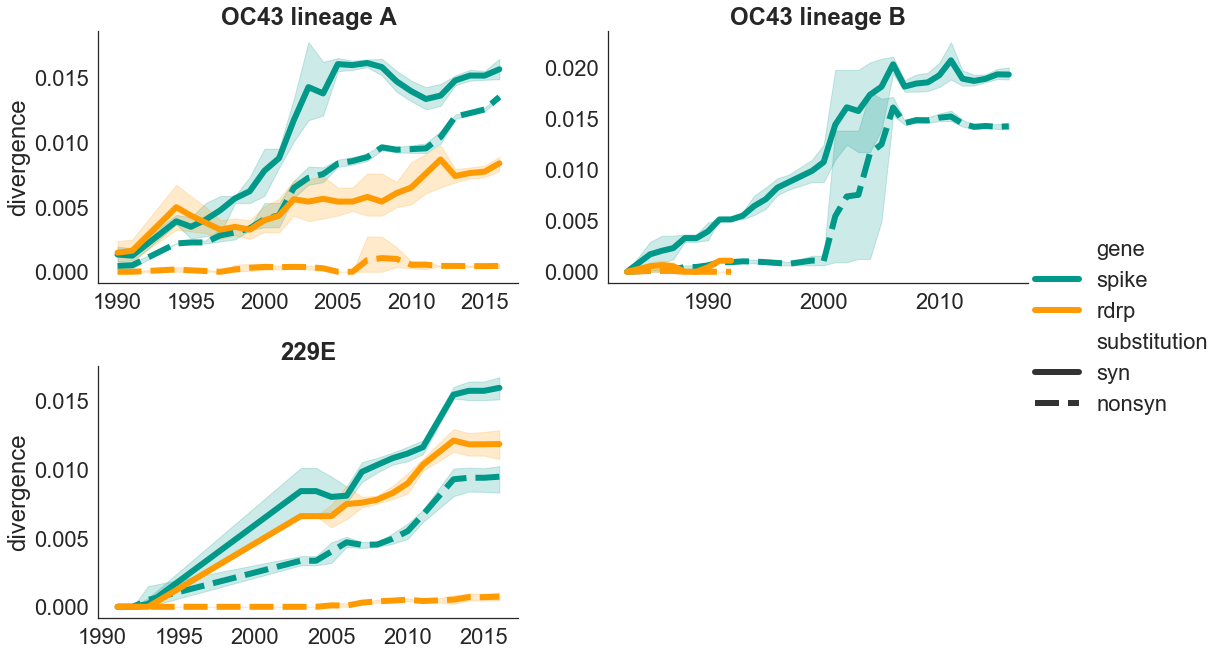

In [168]:
plot_divergence_weighted(['oc43', '229e'], ['spike', 'rdrp'], 3, 2, year_min=1980, filename='figure3a_raw.png')

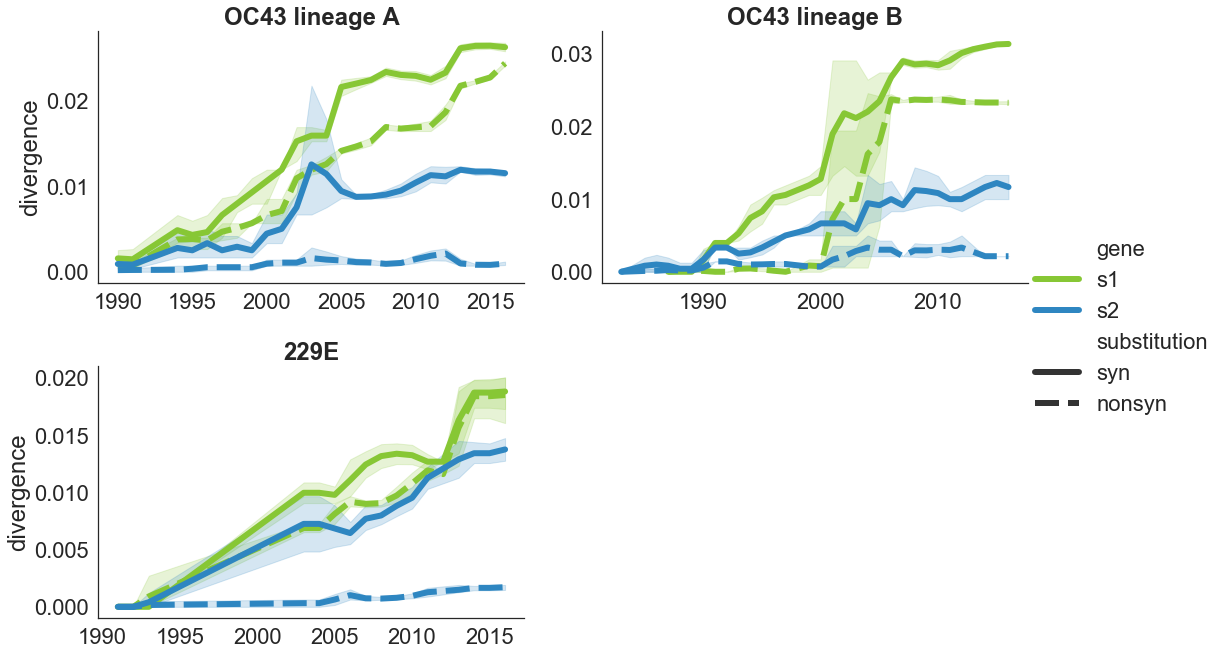

In [166]:
plot_divergence_weighted(['oc43', '229e'], ['s1', 's2'], 3, 2, year_min=1980, filename='figure3b_raw.png')

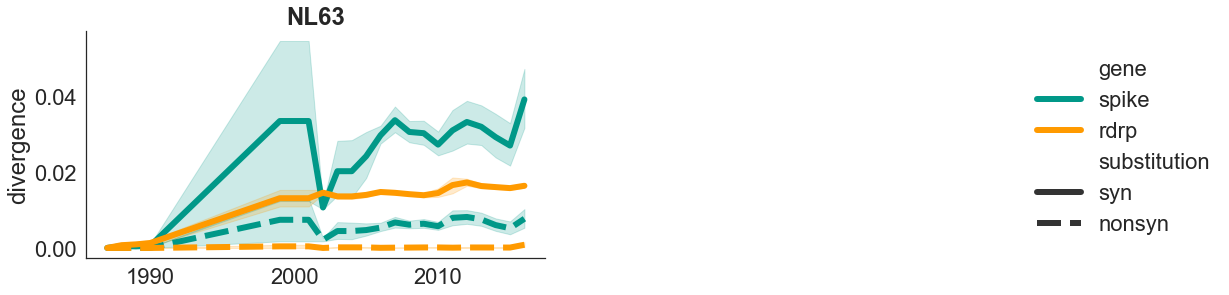

In [172]:
plot_divergence_weighted(['nl63'], ['spike', 'rdrp'], 3, 2, 
                         year_min=1980, filename='figure3supplement_a_weighted.png')

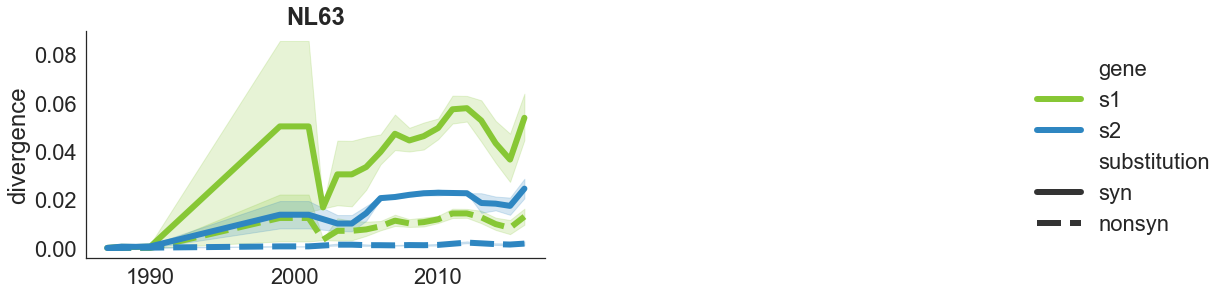

In [173]:
plot_divergence_weighted(['nl63'], ['s1', 's2'], 3, 2, 
                         year_min=1980, filename='figure3supplement_a2_weighted.png')

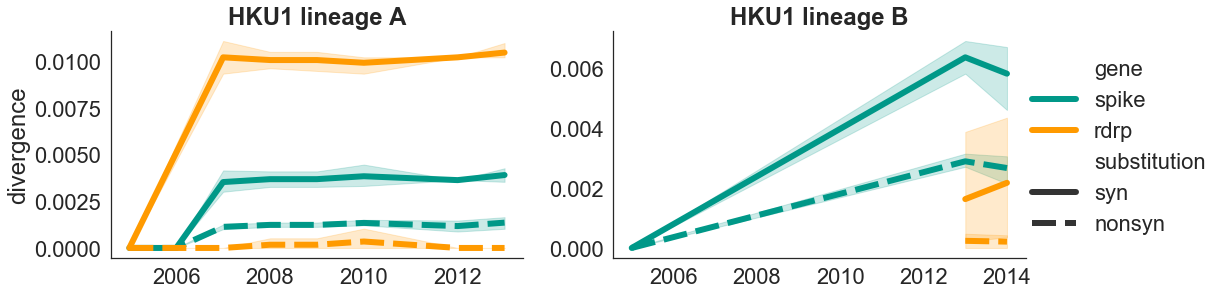

In [174]:
plot_divergence_weighted(['hku1'], ['spike', 'rdrp'], 3, 2, 
                         year_min=1980, filename='figure3supplement_b_weighted.png')

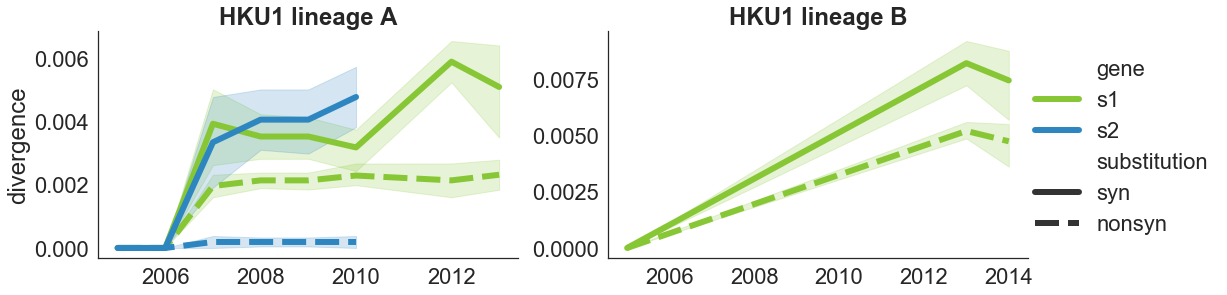

In [175]:
plot_divergence_weighted(['hku1'], ['s1', 's2'], 3, 2, 
                         year_min=1980, filename='figure3supplement_b2_weighted.png')

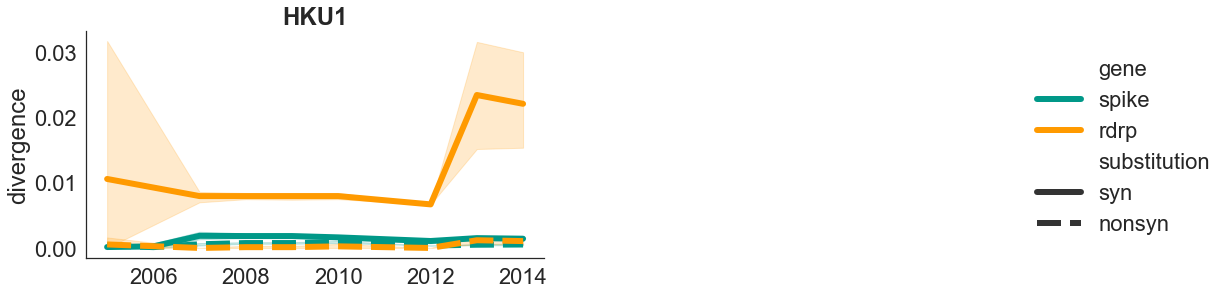

In [184]:
plot_divergence_weighted(['hku1'], ['spike', 'rdrp'], 3, 2, 
                         year_min=1980, filename='figure3supplement_c_weighted.png')

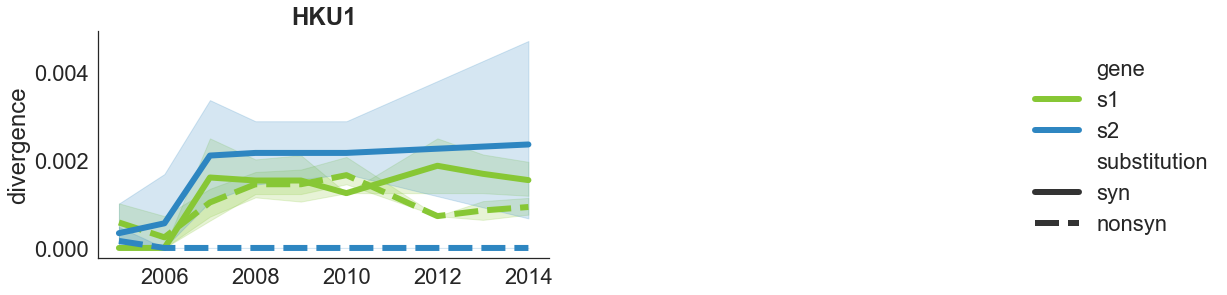

In [185]:
plot_divergence_weighted(['hku1'], ['s1', 's2'], 3, 2, 
                         year_min=1980, filename='figure3supplement_c2_weighted.png')